In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

c:\Users\ziad.abdlhamed\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
# load data
data = pd.read_csv('credit_card_train.csv')
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['Own_Car'] = data['Own_Car'].map({'Yes': 1, 'No': 0})
data['Own_Housing'] = data['Own_Housing'].map({'Yes': 1, 'No': 0})
data['Credit_Card_Issuing'] = data['Credit_Card_Issuing'].map({'Approved': 1, 'Denied': 0})
data.head()

,Num_Children,Gender,Income,Own_Car,Own_Housing,Credit_Card_Issuing
0,1,1,40690,0,1,0
1,2,0,75469,1,0,0
2,1,1,70497,1,1,1
3,1,1,61000,0,0,0
4,1,1,56666,1,1,0


In [3]:
data.describe()

,Num_Children,Gender,Income,Own_Car,Own_Housing,Credit_Card_Issuing
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,2.000892,0.500737,72517.997500,0.700937,0.401295,0.386748
std,1.410704,0.500000,22955.502862,0.457848,0.490161,0.487006
min,0.000000,0.000000,30000.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,53336.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,72077.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,90669.000000,1.000000,1.000000,1.000000
max,11.000000,1.000000,119999.000000,1.000000,1.000000,1.000000


([<matplotlib.patches.Wedge at 0x1c67a1031d0>,
 [Text(-1.0311075005424606, -0.3831674859967632, 'Denied'),
  Text(1.031107464667727, 0.3831675825360133, 'Approved')],
 [Text(-0.5624222730231603, -0.20900044690732536, '61.3%'),
  Text(0.5624222534551236, 0.20900049956509814, '38.7%')])

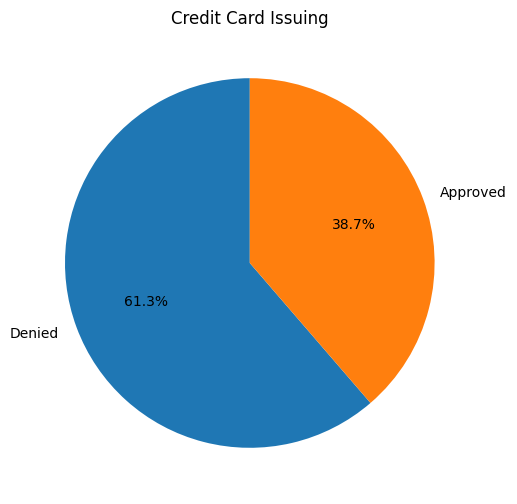

In [4]:
# dataset balance
plt.figure(figsize=(10, 6))
plt.title('Credit Card Issuing')
plt.pie(data['Credit_Card_Issuing'].value_counts(), labels=['Denied','Approved'], autopct='%1.1f%%', startangle=90,)

the dateset seems **unbalanced**

#### Features Engineering

In [5]:
data['Income_per_Child'] = data['Income'] / (data['Num_Children'] + 1)  # avoid division by zero
data['Financial_Stability'] = (data['Own_Car'] & data['Own_Housing']).astype(int)
data['Large_Family'] = (data['Num_Children'] > 3).astype(int)
data['Total_Owned_Assets'] = data['Own_Car'] + data['Own_Housing']
data['Gender_Family_Interaction'] = data['Gender'] * data['Num_Children']
data['Income_Interaction'] = data['Income'] * data['Num_Children']
data['Income_Stability_Score'] = data['Income'] * (data['Own_Housing'] + data['Own_Car'])


**The purpose of feature engineering** in this task is to create new variables that enhance the model’s ability to capture patterns in the data. By adding these features, we aim to improve model accuracy, interpretability, and its ability to generalize to unseen data. The engineered features focus on capturing complex relationships between income, family size, asset ownership, and financial stability, which are critical factors in determining credit card approval.

In [6]:
# List of binary columns to exclude from scaling 
binary_list = ['Gender', 'Own_Housing', 'Own_Car','Financial_Stability','Large_Family','Gender_Family_Interaction', 'Credit_Card_Issuing']
scaler = StandardScaler()
data_to_scale = data.drop(columns=binary_list)
data_scaled_values = scaler.fit_transform(data_to_scale)
data_scaled = pd.DataFrame(data_scaled_values, columns=data_to_scale.columns)
for col in binary_list:
    data_scaled[col] = data[col].values

data_scaled = data_scaled[[c for c in data_scaled if c != 'Credit_Card_Issuing'] + ['Credit_Card_Issuing']] # move target column to the end
data_scaled.head()


,Num_Children,Income,Income_per_Child,Total_Owned_Assets,Income_Interaction,Income_Stability_Score,Gender,Own_Housing,Own_Car,Financial_Stability,Large_Family,Gender_Family_Interaction,Credit_Card_Issuing
0,-0.709499,-1.386510,-0.513083,-0.149193,-0.895182,-0.679179,1,1,0,0,0,1,0
1,-0.000633,0.128553,-0.287988,-0.149193,0.050610,-0.098558,0,0,1,0,0,0,0
2,-0.709499,-0.088040,0.184167,1.310161,-0.639475,0.995356,1,1,1,1,0,1,1
3,-0.709499,-0.501754,-0.037988,-1.608548,-0.720947,-1.358482,1,0,0,0,0,1,0
4,-0.709499,-0.690554,-0.139370,1.310161,-0.758127,0.533550,1,1,1,1,0,1,0


In [7]:
# save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

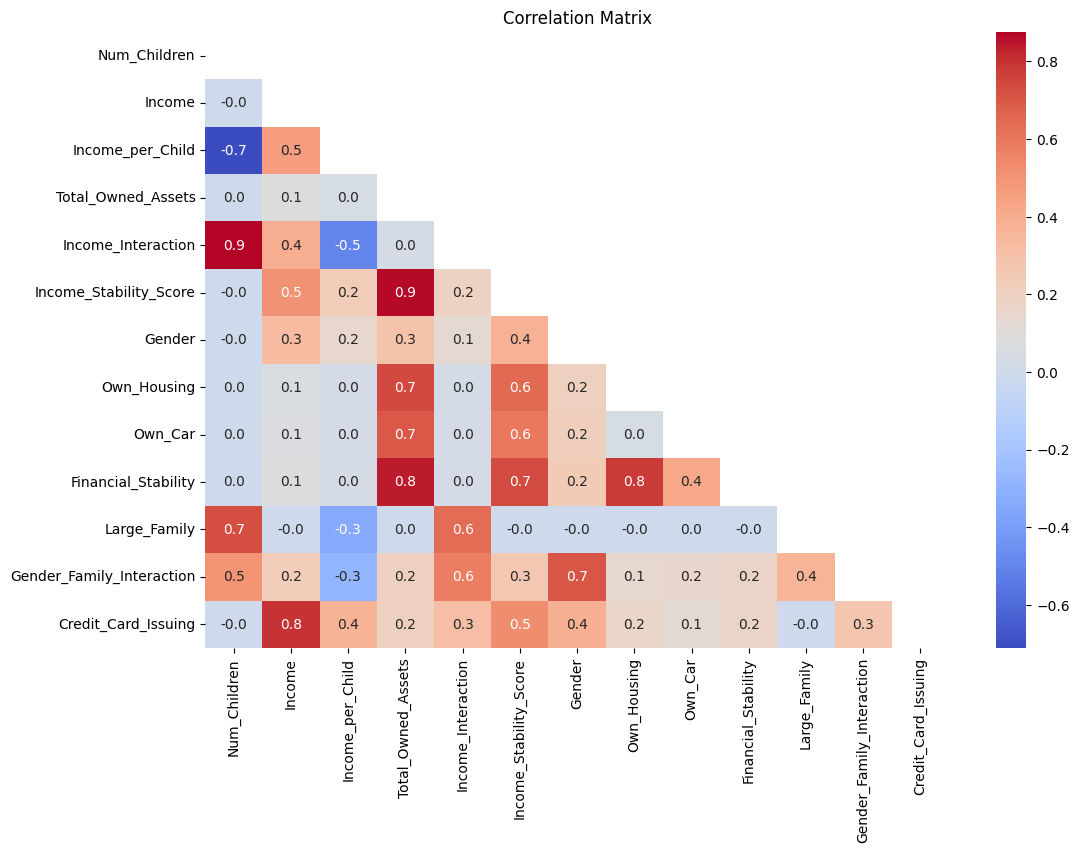

In [8]:
plt.figure(figsize=(12, 8))
corr_matrix = data_scaled.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', mask=mask)
plt.title("Correlation Matrix")
plt.show()

**Key observations** include a strong positive correlation between `Income` and `Income_Stability_Score` with the target, suggesting that higher income levels contribute to a higher likelihood of credit approval. Additionally, features like `Financial_Stability` .`Gender` show moderate correlations with the target


In [9]:
# split data train/test
X = data_scaled.drop(columns='Credit_Card_Issuing')
y = data_scaled['Credit_Card_Issuing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(360000, 12) (40000, 12) (360000,) (40000,)


## Model Training

In [10]:
# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
# param_grid = {
#     'max_depth': [4,5,6,7,8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [1000, 1500, 2000],
# }

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-validation Accuracy:", grid_search.best_score_)

In [25]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.01,
    n_estimators=100,
    random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [26]:
# save model
xgb_model.save_model('credit_card_model.json')

## Model Evaluation

In [13]:
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     24452
           1       0.97      0.96      0.96     15548

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



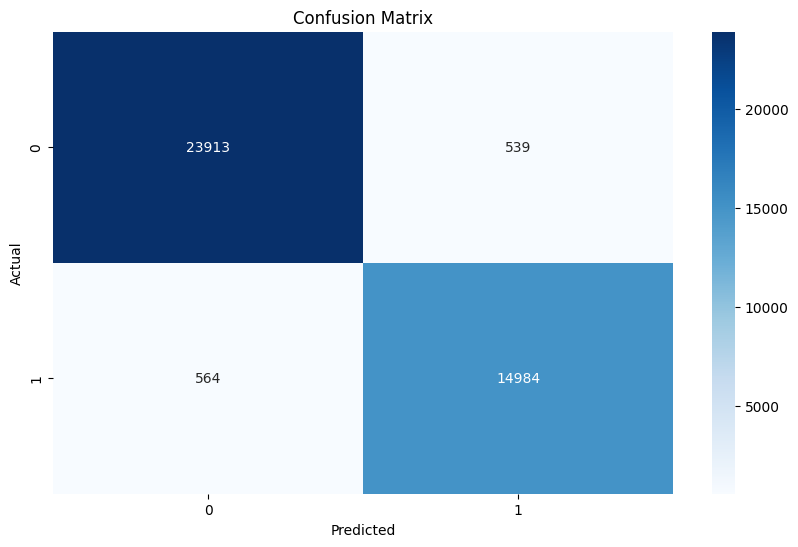

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The **Classification Report** shows results across precision, recall, and F1-score:

- Precision: High precision of 0.98 for class 0 and 0.97 for class 1 indicates that the model accurately identifies instances of both classes, with few false positives.
- Recall: High recall of 0.98 for class 0 and 0.96 for class 1 demonstrates the model’s ability to correctly capture most instances of each class, with few false negatives.
- F1-Score: The F1-score is 0.98 for class 0 and 0.96 for class 1, reflecting a balance between precision and recall.
- Accuracy: The overall accuracy of the model is 97%, showing strong performance across the entire dataset.
- Macro and Weighted Averages: Both the macro and weighted averages are 0.97, indicating consistent model performance across both classes.

### Confusion Matrix
The confusion matrix confirms the high precision and recall seen in the classification report. With only 539 false positives for class 0 and 564 false negatives for class 1, the model effectively distinguishes between the two classes, resulting in an overall accuracy of 97%.

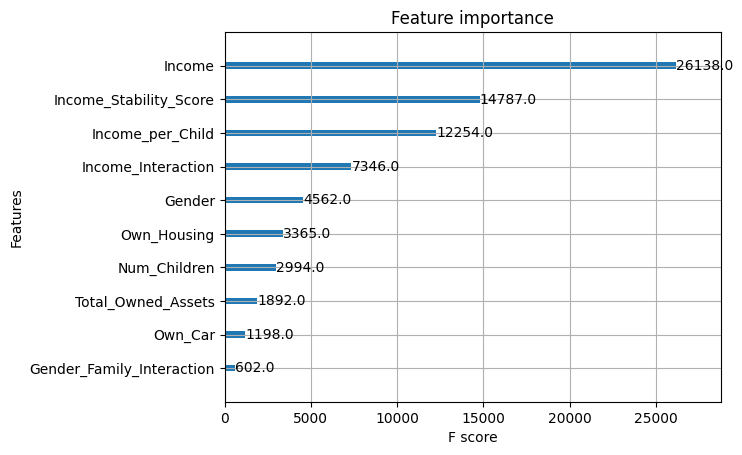

In [15]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

### Feature Importance

The feature importance plot highlights the most influential features in the model’s decision-making process, measured by the F-score.

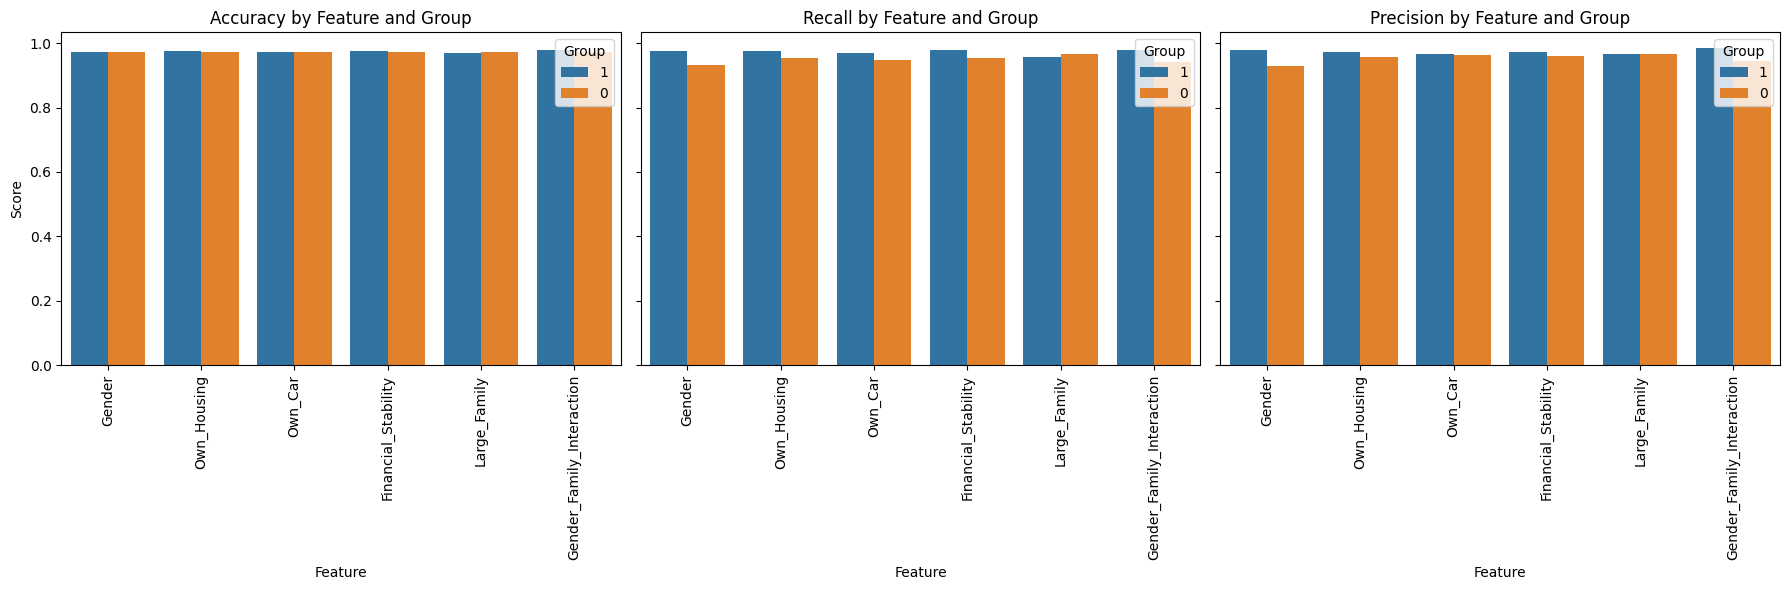

In [16]:
results = {'Feature': [], 'Metric': [], 'Group': [], 'Score': []}

for col in binary_list[:-1]:  # Exclude 'Credit_Card_Issuing'
    y_pred_1 = xgb_model.predict(X_test[X_test[col] == 1])
    y_true_1 = y_test[X_test[col] == 1]
    y_pred_0 = xgb_model.predict(X_test[X_test[col] == 0])
    y_true_0 = y_test[X_test[col] == 0]
    
    # Accuracy
    results['Feature'].extend([col, col])
    results['Metric'].extend(['Accuracy', 'Accuracy'])
    results['Group'].extend(['1', '0'])
    results['Score'].extend([accuracy_score(y_true_1, y_pred_1), accuracy_score(y_true_0, y_pred_0)])
    
    # Recall
    results['Feature'].extend([col, col])
    results['Metric'].extend(['Recall', 'Recall'])
    results['Group'].extend(['1', '0'])
    results['Score'].extend([recall_score(y_true_1, y_pred_1), recall_score(y_true_0, y_pred_0)])
    
    # Precision
    results['Feature'].extend([col, col])
    results['Metric'].extend(['Precision', 'Precision'])
    results['Group'].extend(['1', '0'])
    results['Score'].extend([precision_score(y_true_1, y_pred_1), precision_score(y_true_0, y_pred_0)])

results_df = pd.DataFrame(results)
metrics = ['Accuracy', 'Recall', 'Precision']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    metric_data = results_df[results_df['Metric'] == metric]
    sns.barplot(x='Feature', y='Score', hue='Group', data=metric_data, ax=axes[i])
    axes[i].set_title(f'{metric} by Feature and Group')
    axes[i].set_xlabel('Feature')
    if i == 0:
        axes[i].set_ylabel('Score')
    axes[i].legend(title='Group', loc='upper right')
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

**Overall Insights**
The consistent performance across accuracy, recall, and precision for both groups indicates that the model is well-balanced and handles various feature values effectively.
Minimal performance variations between groups (0 and 1) for each feature suggest that the model is not biased toward any specific value within these features, leading to fair and accurate predictions.

**In summary**, these plots highlight the robustness of the model, showing strong and balanced performance across all key metrics for each feature group.

In [17]:
# Calculate the average income for each gender
average_income_by_gender = data.groupby('Gender')['Income'].mean()
print("Average Income by Gender:")
print(average_income_by_gender)

Average Income by Gender:
Gender
0    65017.724208
1    79996.177573
Name: Income, dtype: float64


**Minimal Bias in Model Performance:**
- Although there is a noticeable income disparity between genders (with males having a higher average income), the model's performance metrics (accuracy, recall, precision) across groups (0 and 1) show minimal variation.
- This suggests that, despite gender differences in income, the model is not disproportionately biased toward either gender. It evaluates both groups fairly in terms of classification accuracy, recall, and precision, reflecting a balanced and fair model.

### SHAP

In [18]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

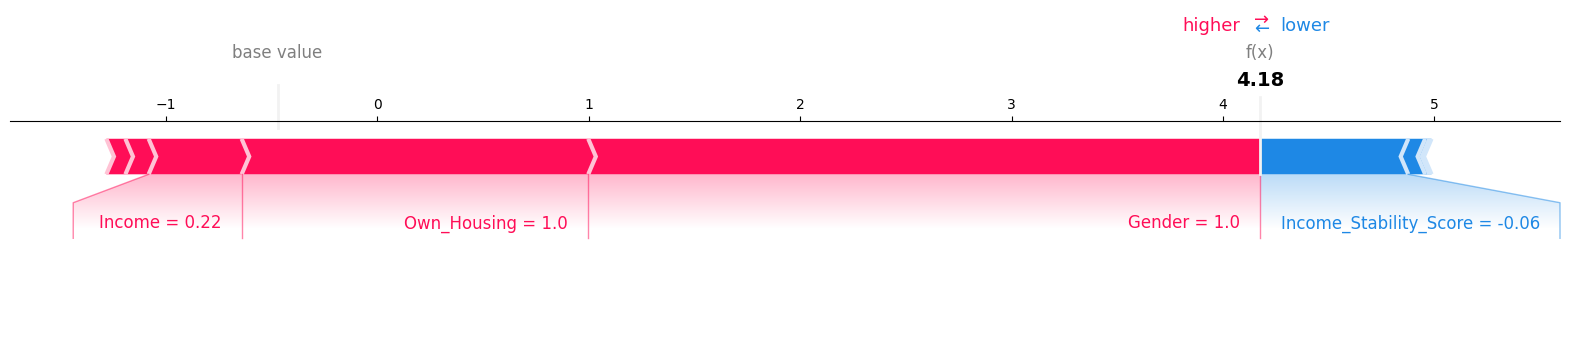

Predicted value of the instance: 1
True value of the instance: 1


In [23]:
def visualize_shap_values(instance_index):
    try:
        if instance_index < 0 or instance_index >= len(X_test):
            raise IndexError("instance_index is out of range.")        
        shap.force_plot(
            explainer.expected_value, 
            shap_values[instance_index].round(2), 
            X_test.iloc[instance_index].round(2), 
            matplotlib=True,
        )
        print("Predicted value of the instance:", y_pred[instance_index])
        print("True value of the instance:", y_test.iloc[instance_index])
    except IndexError as e:
        print(e)
    except Exception as e:
        print("An error occurred:", e)
visualize_shap_values(100)

**Overall Interpretation**

- Positive Contribution: The features `Income`, `Own_Housing`, and `Gender` all push the prediction score significantly towards a positive outcome, suggesting that this instance is likely classified in the positive class (credit approval).

- Negative Contribution: `Income_Stability_Score` has a minor negative effect but does not outweigh the positive contributions from the other features.